# Denoising Autoencoder

In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data', train=True, download=True,
                    transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data', train=False, transform=transforms.ToTensor()),
    batch_size=1
)

Files already downloaded and verified


In [4]:
from utils import ConvAutoencoder

model = ConvAutoencoder().to(device)

In [39]:
import torch.nn as nn

# criterion = nn.BCELoss()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [40]:
def add_noise(inputs, noise_factor = 0.3):
     noisy = inputs + torch.randn_like(inputs) * noise_factor
     noisy = torch.clip(noisy,0.,1.)
     return noisy

In [247]:
def np_img_to_tensor(image):
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform = transforms.ToTensor()
    tensor = transform(image)
    return tensor

def tensor_to_np_img(image):
    # image.permute(1,0,2)
    image = transforms.ToPILImage()(image)
    image = np.array(image)
    # image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    return image

In [281]:
import transformations as trans
import torchvision.transforms as T
from PIL import Image
import cv2

def add_perturbation_from_tensor(inputs, size = 0.3):

    transform_PIL = transforms.ToPILImage()
    transform_tensor = transforms.ToTensor()
    perturbed_imgs = []
    
    # process batch
    for img in inputs:
        img = transform_PIL(img)
        img = np.array(img)
        # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        perturbed_img = trans.brighten(img, size)

        # perturbed_img = cv2.cvtColor(perturbed_img, cv2.COLOR_BGR2RGB)
        perturbed_img = transform_tensor(perturbed_img)

        perturbed_imgs.append(perturbed_img)
    
    perturbed_imgs = torch.cat(perturbed_imgs, 0)
    perturbed_imgs = perturbed_imgs.view(inputs.shape[0], 3, 32, 32)


    # perturbed_imgs = np.array(perturbed_imgs) 
    # perturbed_imgs = torch.from_numpy(perturbed_imgs).permute(0, 3, 2, 1)
    # perturbed_imgs = perturbed_imgs.to(torch.float)
    # perturbed_imgs = torch.clip(perturbed_imgs,0.,1.)
    return perturbed_imgs

In [282]:
# img_list = next(iter(train_loader))
# img = img_list[0][0:2]

# img_np = tensor_to_np_img(img[0])
# plt.imshow(img_np)
# plt.show()

# img_tensor = np_img_to_tensor(img_np)
# img_np = tensor_to_np_img(img_tensor)
# plt.imshow(img_np)
# plt.show()

# type(img_np), type(img_tensor), img_np.shape, img_tensor.shape

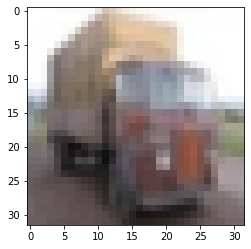

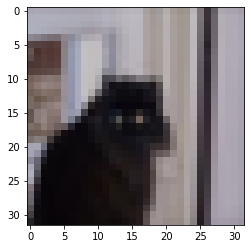

torch.Size([2, 3, 32, 32])
torch.Size([2, 3, 32, 32])


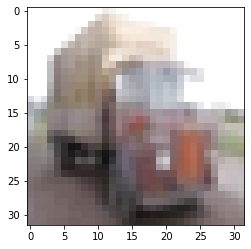

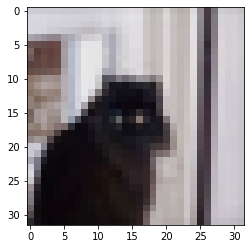

In [283]:
img_list = next(iter(train_loader))
img_list = img_list[0][0:2]

for img in img_list:
    img_np = tensor_to_np_img(img)
    plt.imshow(img_np)
    plt.show()

print(img_list.shape)

img_list = add_perturbation_from_tensor(img_list, 0.2)
print(img_list.shape)

for img in img_list:
    img = tensor_to_np_img(img)
    plt.imshow(img)
    plt.show()

In [284]:
n_epochs = 2

for epoch in range(n_epochs):
    train_loss = 0.0

    for images, labels in train_loader:
        
        images = add_perturbation_from_tensor(images)

        images = images.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
    
     # Validation
    valid_loss = 0.0
    model.eval() 
    for images, labels in test_loader:
        images = images.cuda()
        outputs = model(images)
        loss = criterion(outputs, images)
        valid_loss += loss.item()*images.size(0)

    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(test_loader)}')
            

c:\Users\ivanr\anaconda3\envs\PhD\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1 		 Training Loss: 0.3285629572448102 		 Validation Loss: 0.0071826522562245376
Epoch 2 		 Training Loss: 0.303364601412875 		 Validation Loss: 0.0070124024634948


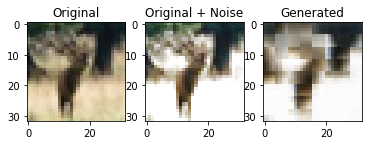

In [302]:
model.eval()
imgs_to_show = 1

with torch.no_grad():
    for data in random.sample(list(test_loader), imgs_to_show):
        
        # Original
        imgs, _ = data
        imgs = imgs.to(device)
        img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
        plt.subplot(131)
        plt.title("Original")
        plt.imshow(img)

        # Original + Noise
        imgs, _ = data
        img = add_perturbation_from_tensor(imgs, 0.5)

        
        img_ = np.transpose(img[0].cpu().numpy(), [1,2,0])
        plt.subplot(132)
        plt.title("Original + Noise")
        plt.imshow(img_)

        # Generated
        img = img.to(device)
        out = model(img)
        outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
        plt.subplot(133)
        plt.imshow(np.squeeze(outimg))
        plt.title("Generated")
        plt.show()